**Miniproject 1: Image generation with a diffusion model**

The goal of this miniproject is to build a diffusion model from scratch to generate images.

There are many flavors of diffusion models. Here, we will take inspiration from *Elucidating the Design Space of Diffusion-Based Generative Models*, a paper by Tero Karras, Miika Aittala, Timo Aila, Samuli Laine, presented at NeurIPS 2022, available [here](https://openreview.net/pdf?id=k7FuTOWMOc7).

In [4]:
import math

import matplotlib.pyplot as plt
import torch

# Background on diffusion models

We have the following two processes:

- **Noising process**: start from clean images, add noise until it is indistinguishable from pure noise.
- **Denoising process**: start from pure noise, iteratively denoiser until it looks like an actual image from the data distribution.

The first one is straightforward, as we just have to degrade images. The second one is much more difficult, and our goal will be to train a neural network to achieve it.

## Noising process

We can gradually degrade an image with a sequence of increasing noise levels $\sigma_0 = 0 < \sigma_1 < \dots < \sigma_T = \sigma_{max}$, in a way that the last step is indistinguishable from pure noise.

![Noising process](images/noising.png)

**Algorithm 1: Noising procedure**
> - Sample an image $y \sim p_{data}$ (i.e. from the dataset)
> - Sample a noise level $\sigma \sim p_{noise}$
> - Sample gaussian noise $\epsilon \sim \mathcal{N}(0, I)$
> - Obtain degraded sample $x$ by adding noise to the image, $x = y + \sigma \epsilon$

**Important**: This is how you will have to degrade clean images during training. 

Notes:

- $p_{data}$ is unknown, but we have access to samples from the dataset.
- We will design a good $p_{noise}$ later.

## Denoising objective

We are looking for a denoising function $D$ that returns the clean image given the noised image $D(x, \sigma) = y $. Note that $D$ is also taking the noise level $\sigma$.

We will thus *train* a parametric function $D_\theta$ with parameters $\theta$, with the following denoising MSE loss,


$$
\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{y,\sigma,\epsilon} \Big[ \| D_\theta(y + \sigma \epsilon, \sigma) - y \|^2 \; \Big] 
\end{equation}
$$

where $y \sim p_{data}, \sigma \sim p_{noise}, \epsilon \sim \mathcal{N}(0, I)$ are sampled as described in the previous section.

## Parameterization and actual loss for the network

We could directly parameterize $D_\theta$ with a neural network, but this would pose several practical issues (details in the paper). Instead, Karras et al. propose the following parameterization of $D_\theta$,

$$
D_\theta(x, \sigma) = c_{skip}(\sigma) \; x + c_{out}(\sigma) \; F_\theta(c_{in}(\sigma)\;x, c_{noise}(\sigma))
$$

Where **$F_\theta$ is the neural network we want to train**. We will define $c_{in},c_{out},c_{skip},c_{noise}$ in the next section, you can ignore them for the moment.

Injecting this parameterization in the denoising loss, we obtain the actual training loss for the network $F_\theta$,
$$
\mathcal{L}(\theta)  = \mathbb{E}_{y,\epsilon,\sigma} \Big[ \; \Vert 
\underbrace{F_\theta \big( c_\text{in}(\sigma) \; (y + \sigma\epsilon), c_{noise}(\sigma) \big)}_\text{Neural network prediction} -
\underbrace{\frac{1}{c_\text{out}(\sigma)} \big( y - c_{skip}(\sigma) \; (y+\sigma\epsilon) \big) }_\text{Neural network training target}
\Vert^2 \; \Big].
$$

**Important**: The left-most term is the output of our neural network, and the right-most term is the training target.

## Defining $c_{in},c_{out},c_{skip},c_{noise}$

We remark that $c_{in},c_{out},c_{skip},c_{noise}$ are only function of the noise level $\sigma$, and we note that,

- $c_{in}(\sigma)$ scales the network input
- $c_{out}(\sigma)$ scales the network output
- $c_{skip}(\sigma)$ controls the skip connection
- $c_{noise}(\sigma)$ transforms the noise level before giving it to the network.

In order to solve the practical issues mentioned above, we define them as follow,

$$
c_{in}(\sigma) = \frac{1}{\sqrt{\sigma_{data}^2 \; + \; \sigma^2}}
$$

$$
c_{out}(\sigma) = \frac{\sigma.\sigma_{data}}{\sqrt{\sigma^2 + \sigma_{data}^2}}
$$

$$
c_{skip}(\sigma) = \frac{\sigma_{data}^2}{\sigma_{data}^2 + \sigma^2}
$$

$$
c_{noise}(\sigma) = ln(\sigma)/4
$$

Where we denote $\sigma_{data}$ the standard deviation of the data distribution. This constant can be estimated from the dataset, and is returned by the `load_dataset_and_make_dataloaders` function described above.

Intuitively,

- $c_{in}$ is chosen to have unit-variance input to the network.
- $c_{out}$ is chosen to have unit-variance target for the network.
- $c_{skip}$ adapts the networks's target depending on the noise level, $\sigma$. When $\sigma \gg \sigma_\text{data}$, we have, $c_\text{skip}(\sigma) \approx 0$, and the training target for $F_\theta$ is dominated by the clean signal, $y$. Conversely, when the noise level is low, $\sigma \approx 0$, we have, $c_\text{skip}(\sigma) \approx 1$, and the target is dominated by the noise, $\epsilon$. This approach yields a robust training objective that makes sure the network is never asked to perform a trivial task.        
- $c_{noise}$ is chosen empirically in the paper.

**Important**: You will need to implement these 4 functions of $\sigma$. 

## Defining $p_{noise}$

Following the paper, we will sample $\sigma$ with a log-normal distribution during training,

In [7]:
def sample_sigma(n, loc=-1.2, scale=1.2, sigma_min=2e-3, sigma_max=80):
    return (torch.randn(n) * scale + loc).exp().clip(sigma_min, sigma_max)

You can plot an histrogram of values of $\sigma$ and verify they are indeed following a log-normal distribution,  

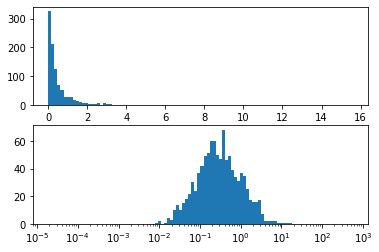

In [8]:
sigma = sample_sigma(1000)

plt.subplot(211)
hist, bins, _ = plt.hist(sigma.tolist(), bins=100)

plt.subplot(212)
logbins = torch.logspace(math.log(bins[0]), math.log(bins[-1]), steps=len(bins))
plt.hist(sigma.tolist(), bins=logbins)
plt.xscale('log')

## Sampling

### Technical / formal remark (see the paper for details)

When sampling, we are actually solving the following differential equation 

$$
dx = -\sigma \nabla_x \log p(x, \sigma) d\sigma
$$

where $\nabla_x \log p(x, \sigma)$ is also known as the "score" function. This score function is thus the object we want to estimate from the beginning, without telling it. There is a formal link between the optimal denoiser $D$ and the score function,

$$
\nabla_x \log p(x, \sigma) = \frac{D(x, \sigma) - x}{\sigma^2}
$$

This link is why we constructed a way to estimate D.

### Defining a discrete schedule of sigmas

To sample a new image, we have to define a sequence of noise levels $\sigma_T = \sigma_{max} > \dots > \sigma_1 > \sigma_0 = 0$. 

While a simple linear interpolation between $\sigma_{max}$ and $0$ would work, Karras et al. empirically found better schedules, and you can use it with the function `build_sigma_schedule` below.

In [5]:
def build_sigma_schedule(steps, rho=7, sigma_min=2e-3, sigma_max=80):
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + torch.linspace(0, 1, steps) * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas

You can visualize the effect of `rho` with the cell below. `rho=7` is the default suggested in the paper, `rho=1` is the linear interpolation.

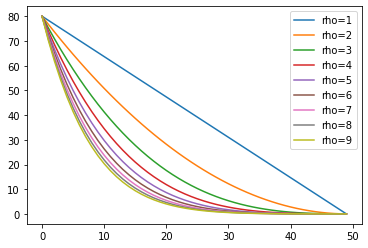

In [6]:
for rho in range(1, 10):
    sigmas = build_sigma_schedule(steps=50, sigma_min=2e-3, sigma_max=80, rho=rho)
    plt.plot(sigmas.tolist(), label=f'rho={rho}')

plt.legend()
plt.show()

### A simple sampling algorithm (Euler's method)

While the paper introduces second order sampling method, we will keep a simple approach here and use Euler's method, implemented below.

In [ ]:
D = lambda x, sigma: x  # dummy D, just for the cell below to work

In [ ]:
sigmas = build_sigma_schedule(steps=50, rho=7)  # Sequence of decreasing sigmas

x = torch.randn(8, 1, 32, 32) * sigmas[0]  # Initialize with pure gaussian noise ~ N(0, sigmas[0])

for i, sigma in enumerate(sigmas):
    
    with torch.no_grad():
        x_denoised = D(x, sigma)  
        # Where D(x, sigma) = cskip(sigma) * x + cout(sigma) * F(cin(sigma) * x, cnoise(sigma)) 
        # and F(.,.) is your neural network
    
    sigma_next = sigmas[i + 1] if i < len(sigmas) - 1 else 0
    d = (x - x_denoised) / sigma
    
    x = x + d * (sigma_next - sigma)  # Perform one step of Euler's method

# -> Final `x` contains the sampled images (8 here)

You can take inspiration from the following code to plot the obtained images.

In [ ]:
from PIL import Image
from torchvision.utils import make_grid

x = x.clamp(-1, 1).add(1).div(2).mul(255).byte()  # [-1., 1.] -> [0., 1.] -> [0, 255]
x = make_grid(x)
x = Image.fromarray(x.permute(1, 2, 0).cpu().numpy())
x

# Instructions

The main goal of the project is to **build a complete training + sampling pipeline**.

We provide here a possible sketch of the project. Also, we provide in the next sections helpers for data loading and some building blocks for a UNet.

**Advised step 1: Build the training pipeline**

Here is a summary of the main steps for the training procedure,

>- Sample an image `y` from the dataset
>- Sample `sigma` from $p_{noise}$
>- Create a noisy image `x` by adding gaussian noise of std `sigma` to the clean image `y`
>- Compute `cin`, `cout`, `cskip` and `cnoise`
>- Forward pass: your network should take two inputs, `cin * x` and `cnoise`, and should output a tensor of the same size as `x`
>- Compute MSE loss with `target = (y - cskip * x) / cout`

Also, we advise to

- Start with FashionMNIST.
- Start with the model provided in `model.py`.
- Use batches and a GPU if you can (on google colab for instance).

**Advised step 2: Build the sampling pipeline**

Here is a summary of the sampling procedure,

>- Create a sequence of decreasing `sigmas` using `build_sigma_schedule`
>- Sample initial gaussian noise of standard deviation `sigmas[0]`
>- To obtain an image, apply iteratively your denoising network, following Euler's method described in the background section 

- At this stage, you should obtain images that look like FashionMNIST, but are quite bad.
- You can make nice visualizations of the iterative denoising process. 

**Advised step 3: Improve architecture**

The model provided in `model.py` is not conditioned on the noise level! 

For now, the `c_noise` argument goes into the provided `NoiseEmbedding` layer (projection on random directions), whose output is then not plugged to anything.

- Find a way to plug this quantity in the model. You can try the first simple approaches that come to your mind.
- Otherwise, a simple (and very effective) approach is to code a **conditional** BatchNorm2d mechanism, where you train a linear layer to map the condition (the noise level here) to the affine parameters of the batch norm. To that end, you should modify the default behavior of `nn.BatchNorm2d` by setting `affine=False` (deactivate learnable parameters of the module), and **add your own linear layer, to predict the affine parameters given the noise embedding**.
- This should give you much better images (barely distinguishable from real images).
- Evaluate your generated images with FID to have a quantive measure of the improvement.
- You can also improve on the initialization of your model, for instance by initializing the weights of `conv2` (in residual blocks) and `conv_out` to zero.

THIS IS ALREADY A GOOD PROJECT AT THIS STAGE! 

**Suggested next steps**

*Idea 1: class-conditioning*

- How can you ask for a specific class?
- Once you have that, you can even play with Classifier-Free Guidance.   

*Idea 2: other dataset, for instance CelebA (face generation)*

*Idea 3: try and improve the architecture*

*Feel free to do anything else you find interesting.*

# Data helpers

We will mostly work with FashionMNIST (and optionally CelebA). Feel free to use more datasets if you want.

| Dataset | Number of images | Split train / valid | Image size | Image range | Preprocessing |
| --- | --- | --- | --- | --- | --- |
| FashionMNIST | 60k | 50k / 10k | 32 x 32 | [-1, 1] | Pad the original 28 x 28 to 32 x 32 |
| CelebA | 162770 | 150k / 12770 | 128 x 128 | [-1, 1] | Center-crop the original 178 x 218 to 178 x 178 then rescale to 128 x 128 |

This preprocessing is already implemented for you. You can use the function `load_dataset_and_make_dataloaders` from the file `data.py` as follows,

In [10]:
from src.data import load_dataset_and_make_dataloaders

gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if gpu else 'cpu')
 
dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=32,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

print(info)

for x, y in dl.train:
    print(x.shape)
    print(y.shape)
    break

DataInfo(image_channels=1, image_size=32, num_classes=10, sigma_data=0.6648)
torch.Size([32, 1, 32, 32])
torch.Size([32])


In [12]:
x.mean(), x.std(), x.min(), x.max()

(tensor(-0.6205), tensor(0.6246), tensor(-1.), tensor(1.))

## Error loading CelebA

You might get an error when downloading CelebA.

You can try and download [here](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8) the following files and place them in your `root_dir/celeba` (with `root_dir` being the directory you pass to the function above).

- *img_align_celeba.zip*
- *list_attr_celeba.txt*
- *identity_CelebA.txt*
- *list_bbox_celeba.txt*
- *list_landmarks_align_celeba.txt*
- *list_eval_partition.txt*